# Portfolio Performance Analysis 

### Overview
This notebook provides a complete framework for analyzing portfolio performance including:
- Risk and return metrics
- Performance attribution by asset class and region
- Benchmark comparison
- Forward-looking forecasts

### Portfolio Structure
- **17 assets** across Equities (55%), Fixed Income (25%), and Alternatives (20%)
- **70% US / 30% UK** market allocation
- Analysis period: 3 years (2022-2025)


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.ticker import PercentFormatter
from matplotlib.dates import YearLocator, DateFormatter
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import os
warnings.filterwarnings('ignore')

In [2]:
PORTFOLIO_TICKERS = {
    # US Market Tickers (70% allocation)
    'ACWI': 0.15,    # Global All-World (Core Equity)
    'QUAL': 0.07,    # Quality Factor (Core Equity)
    'ACWV': 0.05,    # Min Volatility (Core Equity)
    'ESGD': 0.05,    # ESG Aware USA ETF (Satellite Equity)
    'ESGU': 0.05,    # ESG Aware EAFE ETF (Satellite Equity)
    'VWO': 0.03,     # Emerging Markets (Satellite Equity)
    'INDA': 0.02,    # India ETF (Satellite Equity)
    'BNDW': 0.10,    # Global Aggregate (Core Fixed Income)
    #'VCLT': 0.05,    # Credit bonds (Satellite Fixed Income)-->negative return 
    'IGF': 0.05,     # Infrastructure (Alternatives)
    'IAU': 0.10,     # Gold (Alternatives)
    'SHY': 0.05,     # Cash equivalent (Alternatives)
    
    # UK Market Tickers (30% allocation)
    'VHYL.L': 0.1,  # High Dividend Yield (Dividend Equity)
    'JGGI.L': 0.03,  # Dividend Growth (Dividend Equity) - NOTE: Data quality issues (after 5.15)
    'IGLT.L': 0.03,  # UK Gilts (Core Fixed Income)
    'INXG.L': 0.02,  # Index-Linked Gilts (Core Fixed Income)
    'VTIP':0.03,
    'CORP.L': 0.07,  # Corporate Bonds (Satellite Fixed Income)
    #'VCIT':0.05,
    #'CLIM.L': 0.05,  # Green Bonds (Satellite Fixed Income) --> negative return
}

# Asset categorization for performance attribution
ASSET_CATEGORIES = {
    'Core Equity': ['ACWI', 'QUAL', 'ACWV'],
    'Dividend Equity': ['VHYL.L', 'JGGI.L'],
    'Satellite Equity': ['ESGD', 'ESGU', 'VWO', 'INDA'],
    'Core Fixed Income': ['BNDW', 'IGLT.L', 'INXG.L'],
    'Satellite Fixed Income': ['VCLT', 'CORP.L'],
    'Alternatives': ['IGF', 'IAU', 'SHY']
}

## 1. Data Cleaning 

In [ ]:
# Data fetching & Cleaning
def fetch_portfolio_data(tickers_dict, start_date, end_date):
    """
    Fetch historical price data for portfolio tickers from Yahoo Finance.
    
    Handles both US and UK market tickers, providing progress feedback during
    data retrieval. Catches and reports errors for individual tickers without
    stopping the entire process.
    
    Parameters:
    -----------
    tickers_dict : dict
        Dictionary mapping ticker symbols to portfolio weights
        Example: {'ACWI': 0.15, 'VHYL.L': 0.10}
    start_date : str
        Start date in 'YYYY-MM-DD' format
    end_date : str
        End date in 'YYYY-MM-DD' format
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with dates as index and tickers as columns containing closing prices.
        Only includes successfully fetched tickers.
    
    Raises:
    ------
    ValueError
        If no tickers are successfully fetched
    """
    print("🌍 FETCHING PORTFOLIO DATA")
    print("=" * 40)
    
    # Separate US and UK tickers for better tracking
    us_tickers = {k: v for k, v in tickers_dict.items() if not k.endswith('.L')}
    uk_tickers = {k: v for k, v in tickers_dict.items() if k.endswith('.L')}
    
    print(f"📈 US Tickers: {len(us_tickers)}")
    print(f"🇬🇧 UK Tickers: {len(uk_tickers)}")
    print(f"📅 Period: {start_date} to {end_date}")
    print()
    
    all_data = {}
    
    # Fetch data for each ticker
    for ticker, weight in tickers_dict.items():
        try:
            market = "UK" if ticker.endswith('.L') else "US"
            print(f"Fetching {ticker} ({market}) - Weight: {weight:.1%}")
            
            # Use yfinance to get historical data
            stock = yf.Ticker(ticker)
            hist = stock.history(start=start_date, end=end_date, auto_adjust=True)
            
            if not hist.empty:
                all_data[ticker] = hist['Close']
                print(f"✅ Success: {len(hist)} data points")
            else:
                print(f"❌ No data available")
                
        except Exception as e:
            print(f"❌ Error: {str(e)[:50]}...")
    
    print(f"\n📊 Successfully fetched: {len(all_data)}/{len(tickers_dict)} tickers")
    
    if len(all_data) == 0:
        raise ValueError("No tickers were successfully fetched. Please check ticker symbols and date range.")
    
    return pd.DataFrame(all_data)

In [ ]:
def clean_mixed_market_data(df):
    """
    Clean mixed-market data by handling timezone differences and missing values.
    
    Handles US and UK market data with different trading hours by:
    - Removing timezone information
    - Grouping by calendar date (treating same-day timestamps as one)
    - Forward-filling missing values to handle market holidays
    
    Parameters:
    -----------
    df : pd.DataFrame
        Raw price data with datetime index (may have timezone info)
        Columns are ticker symbols, values are closing prices
    
    Returns:
    --------
    pd.DataFrame
        Cleaned DataFrame with:
        - Aligned dates (one row per calendar day)
        - No missing values (forward-filled)
        - Same columns as input
    """
    print("\n🔧 CLEANING MIXED-MARKET DATA")
    print("=" * 35)
    
    # Transform into single date per calendar day
    clean = (
    df                       
    .tz_convert(None)         
    .groupby(df.index.normalize())  # treat 2025-05-31 04:00 and 2025-05-31 23:00 as ONE day
    .last()                   # keep the last close in that calendar bucket
                              # .mean() is OK too; .last() is standard for EOD prices
)
    
    print(f"Original shape: {df.shape}")
    missing_pct = (df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100
    print(f"Missing values: {df.isnull().sum().sum():,} ({missing_pct:.1f}%)")
    
    # Forward fill missing values (carry last known price forward) to handle the time zone differences between US and UK markets
    df_cleaned = clean.fillna(method='ffill')
    
    # Remove any remaining NaN rows (usually just the first few rows)
    df_cleaned = df_cleaned.dropna()
    
    print(f"Cleaned shape: {df_cleaned.shape}")
    print(f"Data retention: {len(df_cleaned)/len(df)*100:.1f}%")
    print(f"Remaining missing values: {df_cleaned.isnull().sum().sum()}")
    
    return df_cleaned

def detect_data_quality_issues(df):
    """
    Detect potential data quality issues by identifying extreme returns.
    
    Flags outliers that may indicate data errors:
    - Returns > 10 standard deviations from mean
    - Single-day moves > 100% (gains) or > 50% (losses)
    
    These could indicate:
    - Stock splits not properly adjusted
    - Data feed errors
    - Corporate actions
    
    Parameters:
    -----------
    df : pd.DataFrame
        Price data with tickers as columns
    
    Returns:
    --------
    dict
        Dictionary mapping ticker symbols to detected issues.
        Keys are tickers with issues, values contain:
        - max_return: Maximum single-day return
        - min_return: Minimum single-day return
        - std_return: Standard deviation of returns
        - extreme_days: Number of days with >3 std dev moves
        Empty dict if no issues found.
    """
    print("\n🔍 DATA QUALITY ANALYSIS")
    print("=" * 30)
    
    issues = {}
    
    # Calculate returns for outlier detection
    returns = df.pct_change(fill_method=None).dropna()
    
    for ticker in returns.columns:
        daily_returns = returns[ticker].dropna()
        if len(daily_returns) > 0:
            max_return = daily_returns.max()
            min_return = daily_returns.min()
            std_return = daily_returns.std()
            
            # Flag extreme values (>10 standard deviations or >100% single day move)
            if (abs(max_return) > 10 * std_return or 
                abs(min_return) > 10 * std_return or
                abs(max_return) > 1.0 or abs(min_return) > 0.5):
                
                issues[ticker] = {
                    'max_return': max_return,
                    'min_return': min_return,
                    'std_return': std_return,
                    'extreme_days': len(daily_returns[abs(daily_returns) > 3 * std_return])
                }
                print(f"⚠️  {ticker}: Potential data quality issues")
                print(f"   Max: {max_return:.2%}, Min: {min_return:.2%}")
            else:
                print(f"✅ {ticker}: Normal data quality")
    
    return issues

## 2. Portfolio Performance

In [5]:
def calculate_portfolio_metrics(price_data, weights_dict):

    print("\n📊 CALCULATING PERFORMANCE METRICS")
    print("=" * 40)
    
    # Calculate individual asset returns
    returns = price_data.pct_change(fill_method=None).dropna()
    
    # Calculate portfolio returns
    portfolio_returns = pd.Series(0, index=returns.index)
    for ticker, weight in weights_dict.items():
        if ticker in returns.columns:
            portfolio_returns += returns[ticker] * weight
    
    # Time period analysis
    years = len(portfolio_returns) / 252  # Assuming 252 trading days per year
    
    # Basic performance metrics
    total_return = (1 + portfolio_returns).prod() - 1
    annual_return = (1 + total_return) ** (1/years) - 1
    volatility = portfolio_returns.std() * np.sqrt(252)
    
    # Risk-adjusted metrics
    risk_free_rate = 0.046  # Current risk-free rate (adjust as needed)
    excess_return = annual_return - risk_free_rate
    sharpe_ratio = excess_return / volatility if volatility > 0 else 0
    
    # Downside risk metrics
    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_vol = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 0
    sortino_ratio = excess_return / downside_vol if downside_vol > 0 else np.inf
    
    # Drawdown analysis
    cumulative = (1 + portfolio_returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Value at Risk (VaR)
    var_95 = np.percentile(portfolio_returns, 5)
    var_99 = np.percentile(portfolio_returns, 1)
    
    # Calmar ratio (annual return / max drawdown)
    calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown != 0 else np.inf
    
    # Compile metrics
    metrics = {
        'Analysis Period (Years)': years,
        'Total Return': total_return,
        'Annual Return': annual_return,
        'Volatility': volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Calmar Ratio': calmar_ratio,
        'Max Drawdown': max_drawdown,
        'VaR (95%)': var_95,
        'VaR (99%)': var_99,
        'Best Day': portfolio_returns.max(),
        'Worst Day': portfolio_returns.min(),
        'Positive Days': (portfolio_returns > 0).sum() / len(portfolio_returns),
        'Data Points': len(portfolio_returns)
    }
    
    # Display metrics
    print("📈 PORTFOLIO PERFORMANCE SUMMARY:")
    print("-" * 45)
    for metric, value in metrics.items():
        if 'Return' in metric or 'Volatility' in metric or 'Drawdown' in metric or 'VaR' in metric or 'Day' in metric:
            print(f"{metric:<25}: {value:>8.2%}")
        elif 'Ratio' in metric:
            if np.isinf(value):
                print(f"{metric:<25}: {'∞':>8}")
            else:
                print(f"{metric:<25}: {value:>8.3f}")
        elif 'Days' in metric:
            print(f"{metric:<25}: {value:>8.1%}")
        else:
            print(f"{metric:<25}: {value:>8.1f}")
    
    return metrics, portfolio_returns, returns

### (1) Attribution Analysis 

In [6]:
def calculate_attribution_analysis(returns_data, weights_dict, categories_dict):

    print("\n📋 PERFORMANCE ATTRIBUTION ANALYSIS")
    print("=" * 45)
    
    attribution = {}
    category_performance = {}
    
    # Individual asset attribution
    for ticker, weight in weights_dict.items():
        if ticker in returns_data.columns:
            asset_returns = returns_data[ticker]
            total_return = (1 + asset_returns).prod() - 1
            years = len(asset_returns) / 252
            annual_return = (1 + total_return) ** (1/years) - 1
            volatility = asset_returns.std() * np.sqrt(252)
            contribution = annual_return * weight
            
            # Find category
            category = 'Other'
            for cat, tickers in categories_dict.items():
                if ticker in tickers:
                    category = cat
                    break
            
            attribution[ticker] = {
                'Category': category,
                'Weight': weight,
                'Annual Return': annual_return,
                'Volatility': volatility,
                'Contribution': contribution,
                'Sharpe Ratio': (annual_return - 0.046) / volatility if volatility > 0 else 0,
                'Market': 'UK' if ticker.endswith('.L') else 'US'
            }
    
    # Category-level attribution
    for category, tickers in categories_dict.items():
        category_weight = 0
        category_contribution = 0
        category_tickers = []
        
        for ticker in tickers:
            if ticker in attribution:
                category_weight += attribution[ticker]['Weight']
                category_contribution += attribution[ticker]['Contribution']
                category_tickers.append(ticker)
        
        if category_weight > 0:
            avg_return = category_contribution / category_weight
            category_performance[category] = {
                'Weight': category_weight,
                'Contribution': category_contribution,
                'Average Return': avg_return,
                'Tickers': category_tickers
            }
    
    # Display results
    print("📊 TOP PERFORMING ASSETS:")
    print("-" * 30)
    sorted_attribution = sorted(attribution.items(), key=lambda x: x[1]['Annual Return'], reverse=True)
    for ticker, data in sorted_attribution[:5]:
        print(f"{ticker:<10}: {data['Annual Return']:>6.1%} (Weight: {data['Weight']:>5.1%})")
    
    print("\n📈 CATEGORY PERFORMANCE:")
    print("-" * 40)
    sorted_categories = sorted(category_performance.items(), key=lambda x: x[1]['Contribution'], reverse=True)
    for category, data in sorted_categories:
        print(f"{category:<20}: {data['Contribution']:>6.2%} contribution")
    
    return attribution, category_performance

### (2) Visualization

In [ ]:
def create_performance_visualizations(portfolio_returns, price_data, attribution, save_path=None):
  
    print("\n📊 CREATING PERFORMANCE VISUALIZATIONS")
    print("=" * 45)
    # Plotting Style
    plt.style.use('default')
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Portfolio Performance Analysis Dashboard', fontsize=16, fontweight='bold')
    
    def format_date_axis(ax, freq="Q"):
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
        ax.tick_params(axis="x", rotation=45)
    
    # 1. Cumulative Returns
    cumulative = (1 + portfolio_returns).cumprod()
    axes[0, 0].plot(cumulative.index, cumulative.values, linewidth=2, color='blue')
    axes[0, 0].set_title('Portfolio Cumulative Returns', fontweight='bold')
    axes[0, 0].set_ylabel('Cumulative Return')
    axes[0, 0].grid(True, alpha=0.3)
    format_date_axis(axes[0, 0])
    
    # 2. Rolling Volatility (3-month)
    rolling_vol = portfolio_returns.rolling(window=63).std() * np.sqrt(252)
    axes[0, 1].plot(rolling_vol.index, rolling_vol.values, color='orange', linewidth=2)
    axes[0, 1].set_title('Rolling 3-Month Volatility', fontweight='bold')
    axes[0, 1].set_ylabel('Volatility')
    axes[0, 1].grid(True, alpha=0.3)
    format_date_axis(axes[0, 1])
    
    # 3. Drawdown
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    axes[0, 2].fill_between(drawdown.index, drawdown.values, 0, alpha=0.3, color='red')
    axes[0, 2].set_title('Portfolio Drawdown', fontweight='bold')
    axes[0, 2].set_ylabel('Drawdown')
    axes[0, 2].grid(True, alpha=0.3)
    format_date_axis(axes[0, 2])
    
    # 4. Return Distribution
    axes[1, 0].hist(portfolio_returns.dropna(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1, 0].axvline(portfolio_returns.mean(), color='red', linestyle='--', 
                      label=f'Mean: {portfolio_returns.mean():.3f}')
    axes[1, 0].set_title('Daily Return Distribution', fontweight='bold')
    axes[1, 0].set_xlabel('Daily Returns')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Asset Contribution
    contributions = [attribution[ticker]['Contribution'] for ticker in attribution.keys()]
    tickers = list(attribution.keys())
    colors = ['blue' if not ticker.endswith('.L') else 'red' for ticker in tickers]
    
    bars = axes[1, 1].bar(range(len(contributions)), contributions, color=colors, alpha=0.7)
    axes[1, 1].set_title('Asset Contribution to Returns', fontweight='bold')
    axes[1, 1].set_ylabel('Annual Contribution')
    axes[1, 1].set_xticks(range(len(tickers)))
    axes[1, 1].set_xticklabels(tickers, rotation=45, ha='right')
    
    # Add value labels on bars
    for bar, contrib in zip(bars, contributions):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{contrib:.1%}', ha='center', va='bottom' if height >= 0 else 'top', fontsize=8)
        
    bar_handles = [Patch(facecolor="blue", label="Non-UK listing"),
                   Patch(facecolor="red",  label="UK / LSE listing")]
    axes[1, 1].legend(handles=bar_handles, loc="upper right")
    
    # 6. Risk-Return Scatter
    returns_list = [attribution[ticker]['Annual Return'] for ticker in attribution.keys()]
    vols_list = [attribution[ticker]['Volatility'] for ticker in attribution.keys()]
    weights_list = [attribution[ticker]['Weight'] for ticker in attribution.keys()]
    
    scatter = axes[1, 2].scatter(vols_list, returns_list, s=[w*1000 for w in weights_list], 
                                alpha=0.6, c=colors)
    axes[1, 2].set_title('Risk-Return Profile (Size = Weight)', fontweight='bold')
    axes[1, 2].set_xlabel('Volatility')
    axes[1, 2].set_ylabel('Annual Return')
    axes[1, 2].grid(True, alpha=0.3)
    
    # Add ticker labels
    for i, ticker in enumerate(tickers):
        axes[1, 2].annotate(ticker, (vols_list[i], returns_list[i]), fontsize=8, ha='center')
        
    colour_handles = [Line2D([], [], marker="o", ls="",
                             markerfacecolor="blue", markeredgecolor="k",
                             label="Non-UK listing"),
                      Line2D([], [], marker="o", ls="",
                             markerfacecolor="red", markeredgecolor="k",
                             label="UK / LSE listing")]
    axes[1, 2].legend(handles=colour_handles,
                      loc="upper left", fontsize=8, frameon=True)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Visualizations saved as: {save_path}")
    
    plt.show()

In [27]:
def plot_contribution_asset_class(attribution,figsize=(14, 5), save_path=None, scatter_size_multiplier=1000, alpha=0.8):
    
    tickers       = list(attribution.keys())
    contributions = [attribution[t]['Contribution'] for t in tickers]
    returns_list  = [attribution[t]['Annual Return'] for t in tickers]
    vols_list     = [attribution[t]['Volatility'] for t in tickers]
    weights_list  = [attribution[t]['Weight'] for t in tickers]

    asset_class_map = {
        # Equities
        'ACWI': 'Equity', 'QUAL': 'Equity', 'ACWV': 'Equity',
        'VHYL.L': 'Equity', 'JGGI.L': 'Equity', 'ESGD': 'Equity',
        'ESGU': 'Equity', 'VWO': 'Equity', 'INDA': 'Equity',
        # Fixed Income
        'IGLT.L': 'Fixed Income', 'BNDW': 'Fixed Income',
        'INXG.L': 'Fixed Income', 'VTIP': 'Fixed Income',  
        'CORP.L': 'Fixed Income',  
        # Alternatives
        'IGF': 'Alternative',  # Fixed: was INFRA.L
        'IAU': 'Alternative', 
        'SHY': 'Alternative'  # Fixed: was CASH
    }
    color_map = {
        'Equity':        '#1f77b4',  # blue
        'Fixed Income':  '#2ca02c',  # green
        'Alternative':   '#ff7f0e'   # orange
    }
    colors = [color_map[asset_class_map.get(t, 'Equity')] for t in tickers]


    fig, (ax_bar, ax_scatter) = plt.subplots(1, 2, figsize=figsize)

    # Bar chart: Asset Contribution
    bars = ax_bar.bar(range(len(contributions)), contributions, color=colors, alpha=alpha)
    ax_bar.set_title('Asset Contribution to Returns', fontweight='bold')
    ax_bar.set_ylabel('Annual Contribution')
    ax_bar.set_xticks(range(len(tickers)))
    ax_bar.set_xticklabels(tickers, rotation=45, ha='right')
    ax_bar.yaxis.set_major_formatter(PercentFormatter(1.0))

    for bar, contrib in zip(bars, contributions):
        h = bar.get_height()
        va = 'bottom' if h >= 0 else 'top'
        ax_bar.text(bar.get_x()+bar.get_width()/2, h, f'{contrib:.1%}',
                    ha='center', va=va, fontsize=8)

    # Legend for bar
    legend_handles = [Patch(color=color, label=cls) for cls, color in color_map.items()]
    ax_bar.legend(handles=legend_handles, loc='upper right', frameon=False, fontsize=9)

    # Scatter: Risk vs Return
    sizes = [w * scatter_size_multiplier * 2 for w in weights_list]  
    scatter = ax_scatter.scatter(vols_list, returns_list, s=sizes, c=colors, alpha=alpha)  
    ax_scatter.set_title('Risk–Return Profile (Size = Weight)', fontweight='bold')
    ax_scatter.set_xlabel('Volatility')
    ax_scatter.set_ylabel('Annual Return')
    ax_scatter.grid(True, alpha=0.3)
    ax_scatter.xaxis.set_major_formatter(PercentFormatter(1.0))
    ax_scatter.yaxis.set_major_formatter(PercentFormatter(1.0))

    # Annotate tickers
    for i, t in enumerate(tickers):
        ax_scatter.annotate(t, (vols_list[i], returns_list[i]),
                            fontsize=8, ha='center', va='center')

    # Legend for scatter
    legend_handles2 = [
        Line2D([0], [0], marker='o', color='w', label=cls,
            markerfacecolor=color_map[cls], markersize=8)
        for cls in color_map
    ]
    ax_scatter.legend(handles=legend_handles2, loc='upper left', frameon=False, fontsize=9)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Figure saved to: {save_path}")

    return fig, (ax_bar, ax_scatter)     

## 3. Metrics Presentation

🎯 COMPREHENSIVE PORTFOLIO ANALYSIS
Portfolio: 17 assets
Total allocation: 100.0%
Analysis period: 3 years

🌍 FETCHING PORTFOLIO DATA
📈 US Tickers: 12
🇬🇧 UK Tickers: 5
📅 Period: 2022-05-15 to 2025-05-15

Fetching ACWI (US) - Weight: 15.0%
✅ Success: 752 data points
Fetching QUAL (US) - Weight: 7.0%
✅ Success: 752 data points
Fetching ACWV (US) - Weight: 5.0%
✅ Success: 752 data points
Fetching ESGD (US) - Weight: 5.0%
✅ Success: 752 data points
Fetching ESGU (US) - Weight: 5.0%
✅ Success: 752 data points
Fetching VWO (US) - Weight: 3.0%
✅ Success: 752 data points
Fetching INDA (US) - Weight: 2.0%
✅ Success: 752 data points
Fetching BNDW (US) - Weight: 10.0%
✅ Success: 752 data points
Fetching IGF (US) - Weight: 5.0%
✅ Success: 752 data points
Fetching IAU (US) - Weight: 10.0%
✅ Success: 752 data points
Fetching SHY (US) - Weight: 5.0%
✅ Success: 752 data points
Fetching VHYL.L (UK) - Weight: 10.0%
✅ Success: 756 data points
Fetching JGGI.L (UK) - Weight: 3.0%
✅ Success: 756 data points


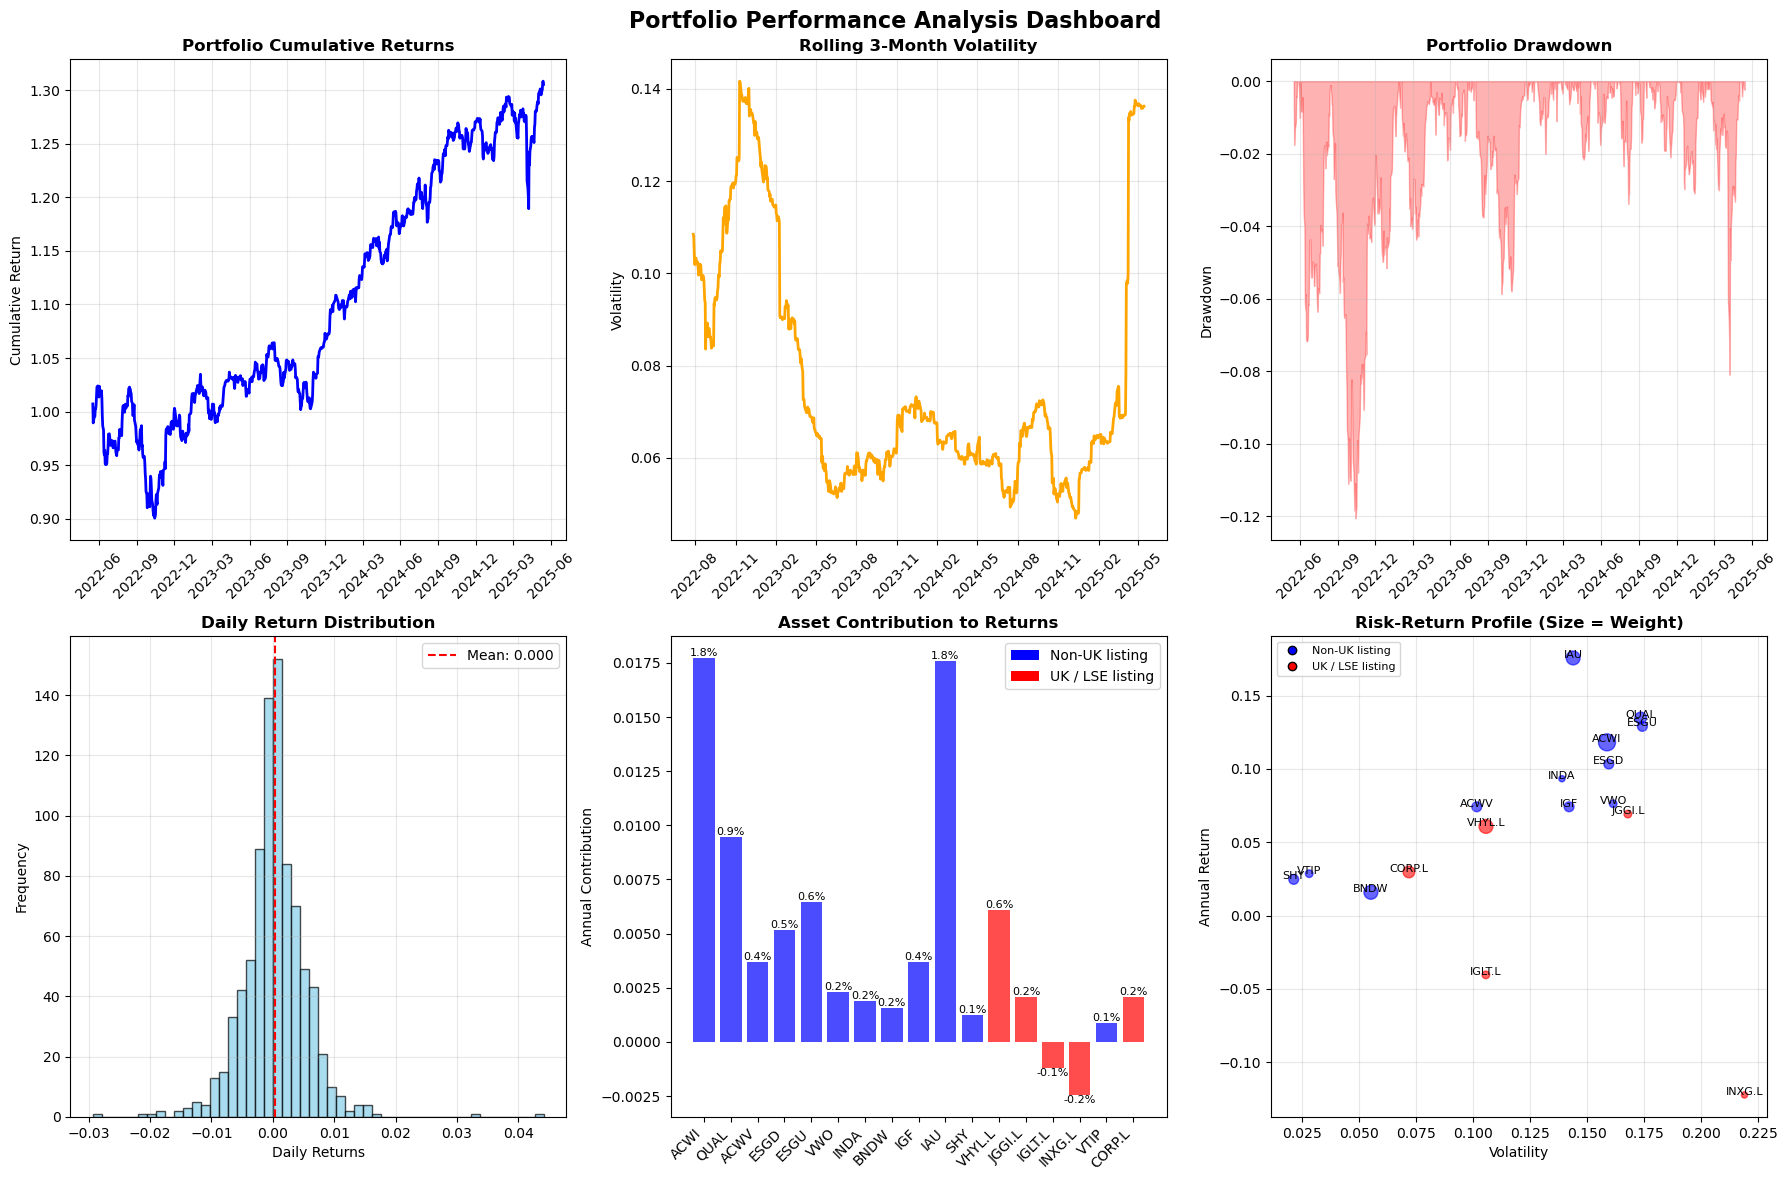


🎉 ANALYSIS COMPLETE!
📊 Portfolio Performance Summary:
   • Annual Return: 8.21%
   • Volatility: 8.37%
   • Sharpe Ratio: 0.431
   • Max Drawdown: -12.06%


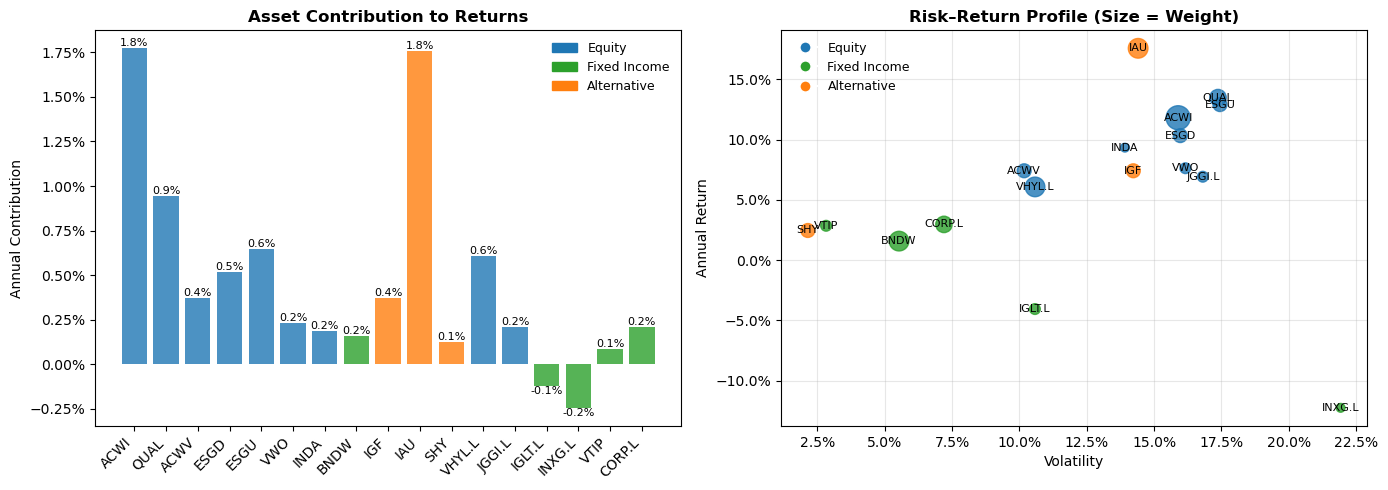

In [28]:
# Final Portfolio Analysis
print("🎯 COMPREHENSIVE PORTFOLIO ANALYSIS")
print("=" * 50)
    
# Set analysis period
end_date = '2025-05-15'
start_date = '2022-05-15'
analysis_years = 3
    
print(f"Portfolio: {len(PORTFOLIO_TICKERS)} assets")
print(f"Total allocation: {sum(PORTFOLIO_TICKERS.values()):.1%}")
print(f"Analysis period: {analysis_years} years")
print()
    
raw_data = fetch_portfolio_data(PORTFOLIO_TICKERS, start_date, end_date)
    
# Data processing
data_issues = detect_data_quality_issues(raw_data)
cleaned_data = clean_mixed_market_data(raw_data)
    
# Performance metrics
metrics, portfolio_returns, asset_returns = calculate_portfolio_metrics(cleaned_data, PORTFOLIO_TICKERS)
    
# Attribution analysis
attribution, category_performance = calculate_attribution_analysis(asset_returns, PORTFOLIO_TICKERS, ASSET_CATEGORIES)
    
# Visualizaiton
create_performance_visualizations(portfolio_returns, cleaned_data, attribution, save_path='portfolio_analysis_dashboard.png')
fig, axes = plot_contribution_asset_class(attribution)
# Export analysis results
metrics_df = pd.DataFrame([metrics])
    
attribution_df = pd.DataFrame(attribution).T
    
category_df = pd.DataFrame(category_performance).T
    
print(f"\n🎉 ANALYSIS COMPLETE!")
print(f"📊 Portfolio Performance Summary:")
print(f"   • Annual Return: {metrics['Annual Return']:.2%}")
print(f"   • Volatility: {metrics['Volatility']:.2%}")
print(f"   • Sharpe Ratio: {metrics['Sharpe Ratio']:.3f}")
print(f"   • Max Drawdown: {metrics['Max Drawdown']:.2%}")
    


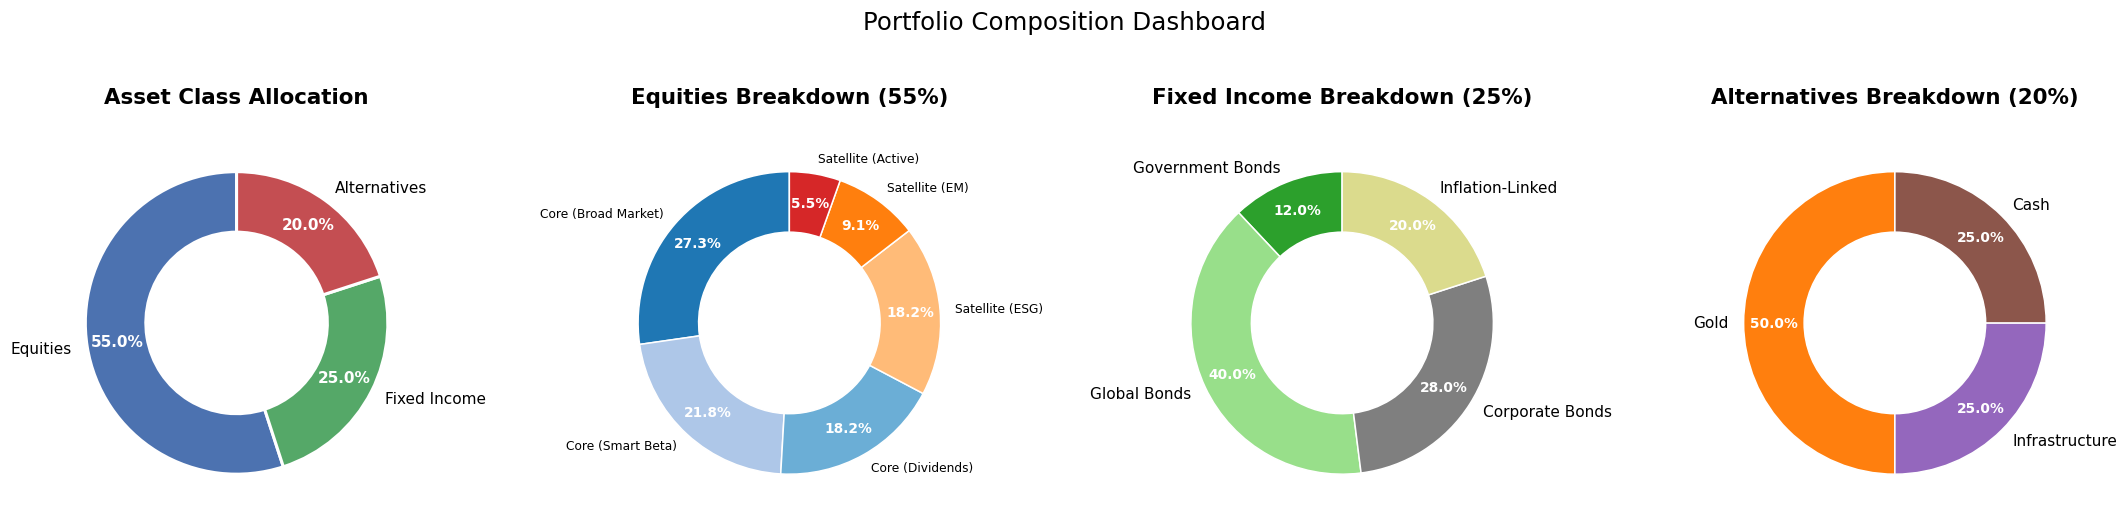

In [43]:
# Data
asset_classes = {
    'Equities': 55,
    'Fixed Income': 25,
    'Alternatives': 20
}

equities = {
    'Core (Broad Market)': 15,
    'Core (Smart Beta)': 12,
    'Core (Dividends)': 10,
    'Satellite (ESG)': 10,
    'Satellite (EM)': 5,
    'Satellite (Active)': 3
}

fixed_income = {
    'Government Bonds': 3,
    'Global Bonds': 10,
    'Corporate Bonds': 7,
    'Inflation-Linked': 5
}

alternatives = {
    'Gold': 10,
    'Infrastructure': 5,
    'Cash': 5
}

# Set up the dashboard
plt.figure(figsize=(20, 5))  # Wider figure to fit 4 plots

# ----------------------------
# 1. Primary Donut (Asset Classes)
# ----------------------------
plt.subplot(1, 4, 1)  # 1 row, 4 columns, position 1
wedges, texts, autotexts = plt.pie(
    asset_classes.values(), 
    labels=asset_classes.keys(), 
    autopct='%1.1f%%', 
    startangle=90, 
    wedgeprops={'width': 0.4, 'edgecolor': 'white', 'linewidth': 2},
    colors=['#4C72B0', '#55A868', '#C44E52'],  # Blue, Green, Red
    pctdistance=0.8 
)
plt.title('Asset Class Allocation', fontsize=14, pad=20)
plt.setp(autotexts, size=10, weight='bold', color='white')  

# ----------------------------
# 2. Equities Drill-Down
# ----------------------------
plt.subplot(1, 4, 2)
equity_colors = ['#1f77b4', '#aec7e8', '#6baed6', '#ffbb78', '#ff7f0e', '#d62728']
wedges, texts, autotexts = plt.pie(
    equities.values(), 
    labels=equities.keys(), 
    autopct=lambda p: f'{p:.1f}%' if p > 5 else '',  # Hide small percentages
    startangle=90,
    wedgeprops={'width': 0.4, 'edgecolor': 'white', 'linewidth': 1},
    colors=equity_colors,
    pctdistance=0.8  # Position percentage labels on the ring
)
plt.title('Equities Breakdown (55%)', fontsize=14, pad=20)
plt.setp(texts, size=8)  # Smaller labels for crowded segments
plt.setp(autotexts, size=9, weight='bold', color='white')  

# ----------------------------
# 3. Fixed Income Drill-Down
# ----------------------------
plt.subplot(1, 4, 3)
fi_colors = ['#2ca02c', '#98df8a', '#7f7f7f', '#dbdb8d']
wedges, texts, autotexts = plt.pie(
    fixed_income.values(), 
    labels=fixed_income.keys(), 
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'width': 0.4, 'edgecolor': 'white', 'linewidth': 1},
    colors=fi_colors,
    pctdistance=0.8  
)
plt.title('Fixed Income Breakdown (25%)', fontsize=14, pad=20)
plt.setp(autotexts, size=9, weight='bold', color='white')  

# ----------------------------
# 4. Alternatives Drill-Down
# ----------------------------
plt.subplot(1, 4, 4)
alt_colors = ['#ff7f0e', '#9467bd', '#8c564b']
wedges, texts, autotexts = plt.pie(
    alternatives.values(), 
    labels=alternatives.keys(), 
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'width': 0.4, 'edgecolor': 'white', 'linewidth': 1},
    colors=alt_colors,
    pctdistance=0.8  
)
plt.title('Alternatives Breakdown (20%)', fontsize=14, pad=20)
plt.setp(autotexts, size=9, weight='bold', color='white')  

# Final adjustments
plt.tight_layout(pad=3.0)  # Prevent overlapping
plt.suptitle('Portfolio Composition Dashboard', fontsize=16, y=1.05)
plt.show()

## 4. Relative Analysis - Benchmarked against FTSE UK Private Investor Income Balanced Index

### (1) Benchmark Performance

In [44]:

#Relative Performance --> Benchmark:FTSE UK Private Investor Income Balanced Index
plt.style.use('default')          

benchmark_data = pd.read_excel('Benchmark.xlsx')
benchmark_data = benchmark_data.set_index(["Date"])
benchmark_data.index = pd.to_datetime(benchmark_data.index)
benchmark_data_reversed = benchmark_data.sort_index(ascending=True)
benchmark_data_reversed

,Dividend adjusted Last Price
Date,
2022-05-16,4871.59
2022-05-17,4873.99
2022-05-18,4822.51
2022-05-19,4784.59
2022-05-20,4805.33
...,...
2025-05-09,5812.43
2025-05-12,5899.83
2025-05-13,5903.89


In [30]:
benchmark_returns=benchmark_data_reversed['Dividend adjusted Last Price'].pct_change(fill_method=None).dropna()
benchmark_total_return = (1 + benchmark_returns).prod() - 1
benchmark_annual_return = (1 + benchmark_total_return) ** (1/3) - 1
benchmark_volatility = benchmark_returns.std() * np.sqrt(252)
    
# Risk-adjusted metrics
risk_free_rate = 0.046  # Current risk-free rate 
excess_return = benchmark_annual_return - risk_free_rate
benchmark_sharpe_ratio = excess_return / benchmark_volatility if benchmark_volatility > 0 else 0
print(f'Benchmark 3y Return:{benchmark_total_return:.2%}')
print(f'Benchmark Annualized Return:{benchmark_annual_return:.2%}')
print(f'Benchmark Volatility:{benchmark_volatility:.2%}')
print(f'Benchmark Sharpe Ratio:{benchmark_sharpe_ratio:.2f}')


Benchmark 3y Return:21.60%
Benchmark Annualized Return:6.74%
Benchmark Volatility:7.63%
Benchmark Sharpe Ratio:0.28


In [31]:
# Align calendars & forward-fill weekends/holidays
portfolio_returns1=portfolio_returns.copy()
benchmark_returns1=benchmark_returns.copy()
benchmark_returns1.index = pd.to_datetime(benchmark_returns1.index).date
portfolio_returns1.index=pd.to_datetime(portfolio_returns1.index).date
data = pd.concat([benchmark_returns1, portfolio_returns1], axis=1).dropna()
data = data.asfreq('B').ffill()
data = data.rename(columns={'Dividend adjusted Last Price':'benchmark',0:'portfolio'})
data

,benchmark,portfolio
2022-05-17,0.000493,0.007206
2022-05-18,-0.010562,-0.017576
2022-05-19,-0.007863,0.002559
2022-05-20,0.004335,0.002198
2022-05-23,0.004711,0.007414
...,...,...
2025-05-08,0.002312,-0.003370
2025-05-09,0.001183,0.001716
2025-05-12,0.015037,0.005502
2025-05-13,0.000688,0.000600


### (2) Relative Performance Dashboard

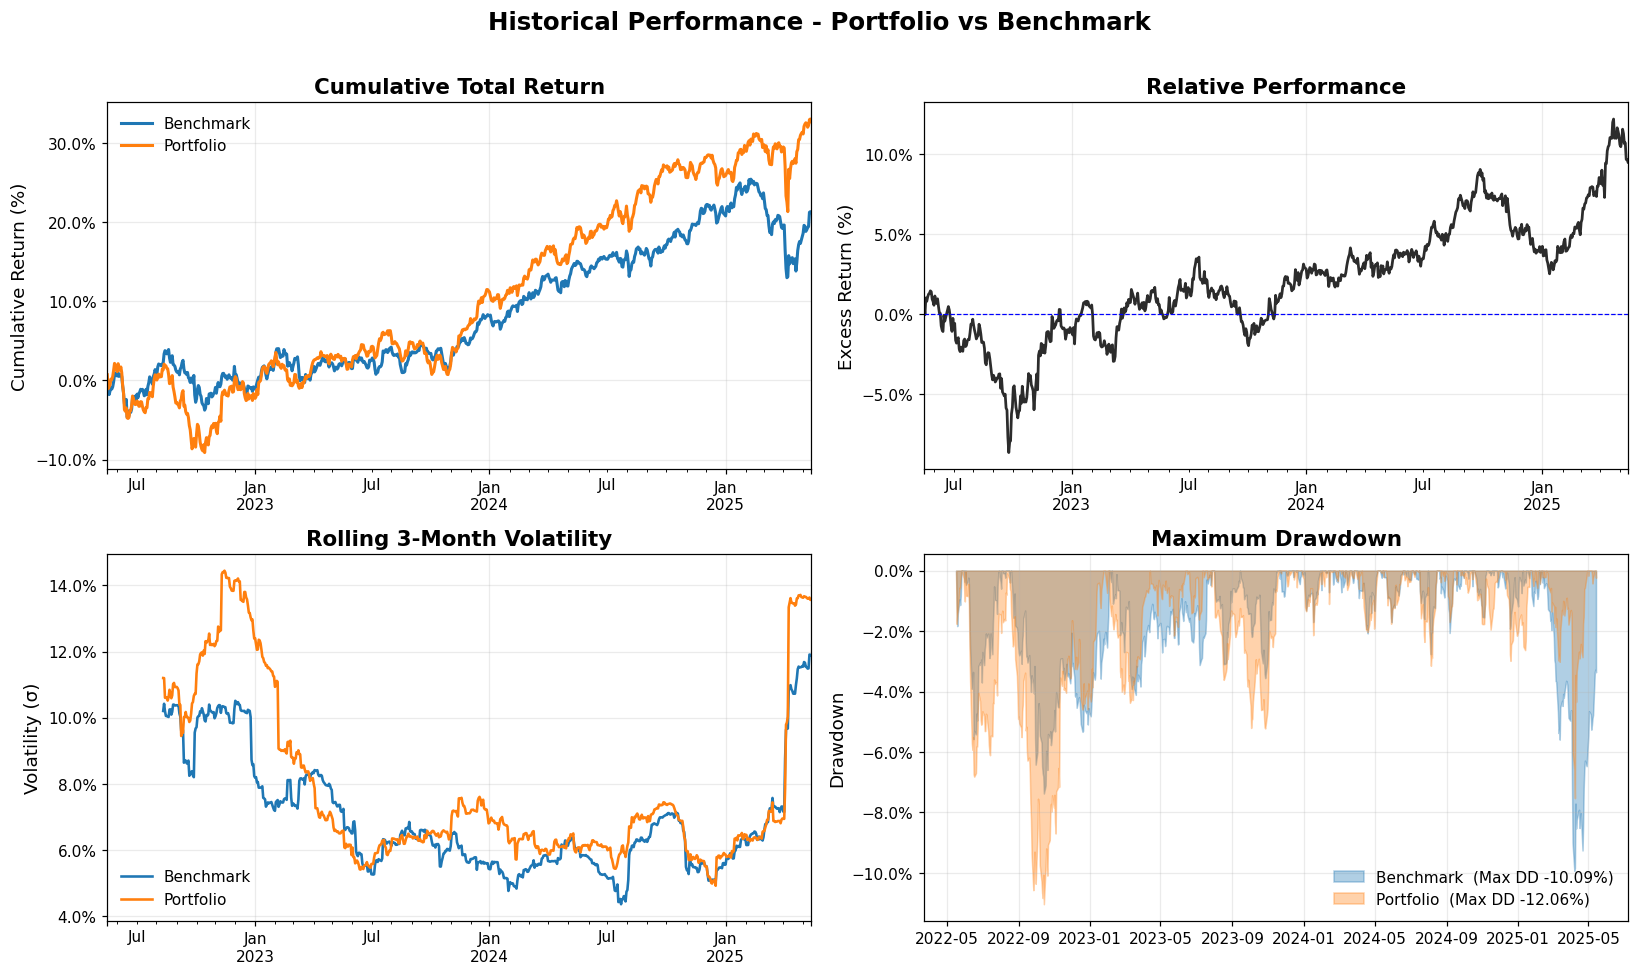

Maximum draw‑down summary:
  Benchmark : -9.93%
  Portfolio : -11.03%


In [33]:
plt.rcParams.update({
    "figure.dpi": 110,
    "font.family": "sans-serif",
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.titleweight": "semibold",
    "legend.fontsize": 10,
})

palette = {"benchmark": "#1f77b4",  # muted blue
           "portfolio": "#ff7f0e"}  # muted orange

rets = data[["benchmark", "portfolio"]]
ann_factor = 252

total=(1 + rets).cumprod()-1
cum = (1 + rets).cumprod()
rel = cum["portfolio"] / cum["benchmark"] - 1
roll_vol = rets.rolling(window=63).std() * ann_factor ** 0.5
dd = cum / cum.cummax() - 1
max_dd_info = {col: dd[col].min() for col in dd.columns}

fig, axes = plt.subplots(2, 2, figsize=(15, 9))
(ax_cum, ax_rel), (ax_vol, ax_dd) = axes

# 1. Cumulative Total Return (top-left)
for col in ["benchmark", "portfolio"]:
    total[col].plot(ax=ax_cum, linewidth=2, color=palette[col], label=col.title())
ax_cum.set_title("Cumulative Total Return")
ax_cum.set_ylabel("Cumulative Return (%)")
ax_cum.yaxis.set_major_formatter(PercentFormatter(1.0))
ax_cum.legend(frameon=False)

# 2. Relative Performance (top-right)
rel.plot(ax=ax_rel, color="#2c2c2c", linewidth=1.8)
ax_rel.axhline(0, linestyle="--", linewidth=0.8, color="blue")
ax_rel.set_title("Relative Performance")
ax_rel.set_ylabel("Excess Return (%)")
ax_rel.yaxis.set_major_formatter(PercentFormatter(1.0))

# 3. Rolling Volatility – Portfolio & Benchmark (bottom‑left)
for col in ["benchmark", "portfolio"]:
    roll_vol[col].plot(ax=ax_vol, linewidth=1.7, label=col.title(), color=palette[col])
ax_vol.set_title("Rolling 3‑Month Volatility")
ax_vol.set_ylabel("Volatility (σ)")
ax_vol.yaxis.set_major_formatter(PercentFormatter(1.0))
ax_vol.legend(frameon=False)

# 4. Max Drawdown – Portfolio & Benchmark (bottom‑right)
labels = {
    'benchmark':-0.1009 ,  # -12.06%
    'portfolio': -0.1206   # -10.09%
}
max = pd.DataFrame(labels, index=[0])

for col in ["benchmark", "portfolio"]:
    ax_dd.fill_between(dd.index, dd[col], 0, alpha=0.35, color=palette[col],
                       label=f"{col.title()}  (Max DD {max[col].iloc[0]:.2%})")
ax_dd.set_title("Maximum Drawdown")
ax_dd.set_ylabel("Drawdown")
ax_dd.yaxis.set_major_formatter(PercentFormatter(1.0))
ax_dd.legend(frameon=False, loc="lower right")


fig.suptitle("Historical Performance - Portfolio vs Benchmark", fontsize=16, weight="bold")
fig.tight_layout(rect=[0, 0.00, 1, 0.97])
plt.show()


print("Maximum draw‑down summary:")
for k, v in max_dd_info.items():
    print(f"  {k.title():10s}: {v:.2%}")

### (3) Portfolio vs Benchmark

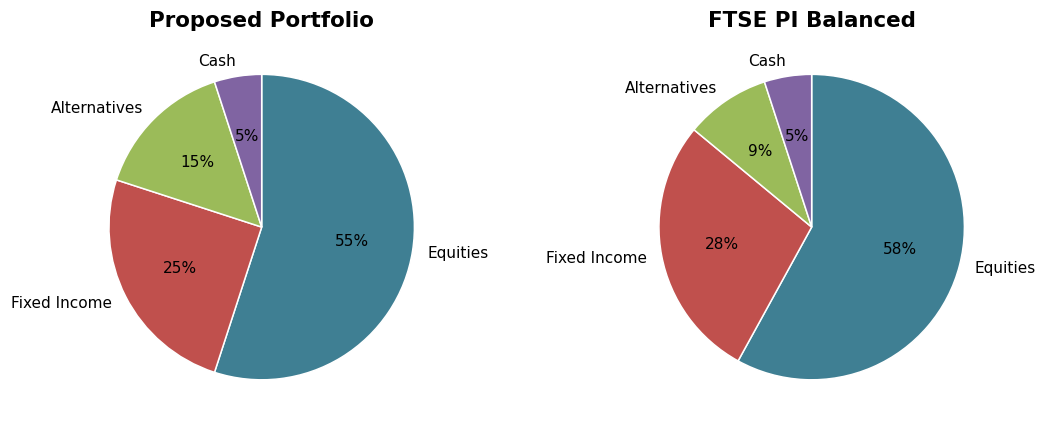

In [34]:
# Rationale for Benchmark
labels = ['Equities', 'Fixed Income', 'Alternatives', 'Cash']
port_weights   = [0.55, 0.25, 0.15, 0.05]      # example 20 % alts split 15+5
balanced_weights = [0.58, 0.28, 0.09, 0.05]    # FTSE PI Balanced March-25 fact-sheet

colours = ['#3f7f93', '#c0504d', '#9bbb59', '#8064a2']  # keep consistent!

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for ax, wts, title in zip(axes, [port_weights, balanced_weights],
                          ['Proposed Portfolio', 'FTSE PI Balanced']):
    ax.pie(wts, labels=labels, colors=colours, autopct='%1.0f%%',
           startangle=90, counterclock=False, wedgeprops=dict(edgecolor='w'))
    ax.set_title(title)

plt.tight_layout()
plt.show()

## 5. Forecasting


Expected 5‑year CAGR ≈ 5.76%
Expected annual volatility ≈ 10.57%

Asset Contributions (basis‑points):
 Developed Equity    292.5
Emerging Equity      72.5
Government Bonds     52.0
IG Credit            36.8
TIPS                 21.5
Infrastructure       36.0
Gold                 47.5
Cash                 17.5
Name: Contribution (bp), dtype: float64


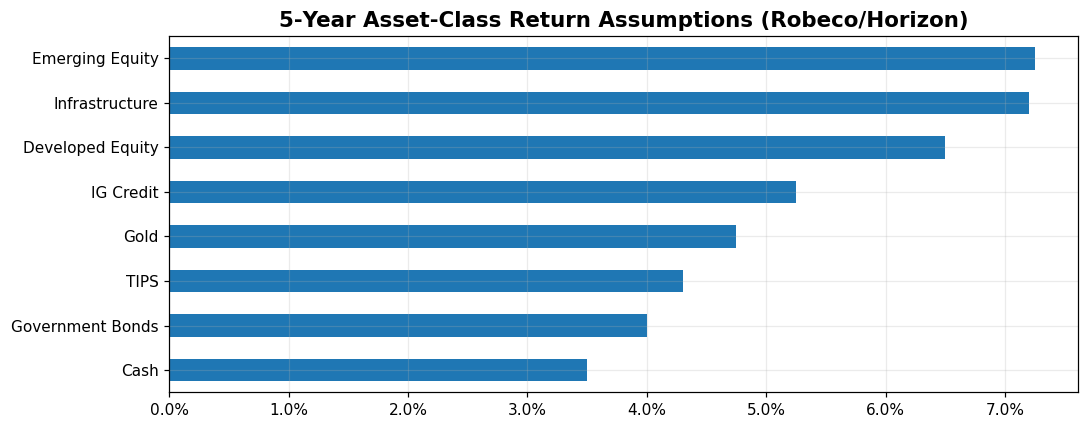

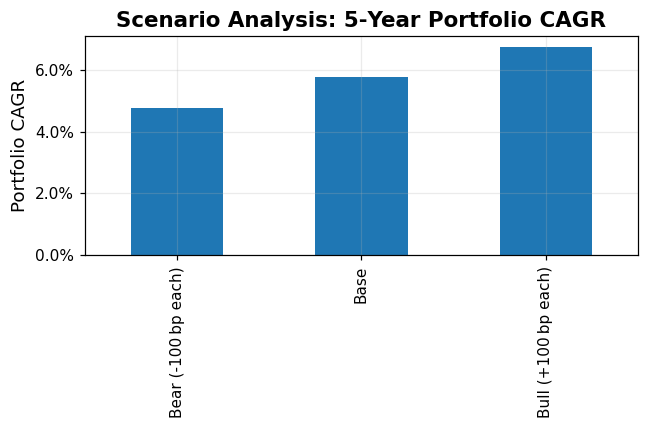

In [36]:
#Future Performance Forecast
"""
5‑year expected return is forecasted using Robeco (5‑year) and Horizon
(10‑year) capital‑market assumptions

Note: the volatility calculation is illustrative.  It uses a very coarse
correlation assumption (0.25 among risky assets, 0 with Cash)
"""

# 1. Portfolio Weights
w = pd.Series(
    {
        "Developed Equity": 0.45,   # MSCI ACWI core + smart‑beta + dividend ETFs
        "Emerging Equity": 0.10,    # Vanguard EM + INDA
        "Government Bonds": 0.13,   # Gilts + global aggregate
        "IG Credit": 0.07,          # Global corporate bond UCITS ETF (GBP‑hedged)
        "TIPS": 0.05,               # INXG + VTIP
        "Infrastructure": 0.05,     # Global listed infrastructure ETF
        "Gold": 0.10,               # Physical gold ETC
        "Cash": 0.05,               # Cash & equivalents
    },
    name="Weight",
)

# 2. Expected Returns & Volatilities(Robeco 5‑yr base & Horizon medians)
# ----------------------------------------------------------------------------
# Robeco base‑case (EUR investor) returns, Horizon medians where Robeco silent.

exp_ret = pd.Series(
    {
        "Developed Equity": 0.065,         # 6.5 %  
        "Emerging Equity": 0.0725,         # 7.25 % 
        "Government Bonds": 0.040,         # 4.0 %  
        "IG Credit": 0.0525,               # 5.25 % 
        "TIPS": 0.043,                     # 4.3 %  
        "Infrastructure": 0.072,            # 7.2 % 
        "Gold": 0.0475,                    # proxy: commodities 4.75 % 
        "Cash": 0.035,                     # 3.5 % 
    },
    name="Exp Return",
)

# Horizon average standard deviations (10‑yr horizon) where available
exp_vol = pd.Series(
    {
        "Developed Equity": 0.1806,   # Non‑US Dev eq std‑dev 18.06 % 
        "Emerging Equity": 0.2361,    # EM eq std‑dev 23.61 %  
        "Government Bonds": 0.0733,  # Non‑US Dev debt 7.33 %  
        "IG Credit": 0.0590,         # US core bonds 5.9 %    
        "TIPS": 0.061,               # TIPS 6.1 %            
        "Infrastructure": 0.160,     # Infrastructure 16 %    
        "Gold": 0.178,               # Commodities 17.8 %     
        "Cash": 0.011,               # Cash 1.1 %             
    },
    name="Exp Vol",
)

# 3. Portfolio Expected Return & Simple Volatility Estimate

port_ret = float((w * exp_ret).sum())

# simple correlation matrix: 0.25 among risky assets, 0 with Cash
assets = w.index.tolist()
base_corr = 0.25
corr = pd.DataFrame(np.full((len(assets), len(assets)), base_corr), index=assets, columns=assets)
np.fill_diagonal(corr.values, 1.0)
# Zero‑correlate Cash rows/cols
corr.loc["Cash", :] = 0.0
corr.loc[:, "Cash"] = 0.0
corr.loc["Cash", "Cash"] = 1.0

cov = corr * np.outer(exp_vol, exp_vol)
port_var = float(w @ cov @ w)
port_vol = port_var ** 0.5

# 4. OUTPUT SUMMARY TABLE
summary = pd.DataFrame({"Weight": w, "Exp Return": exp_ret, "Exp Vol": exp_vol})
summary["Contribution (bp)"] = summary["Weight"] * summary["Exp Return"] * 10000

print("\nExpected 5‑year CAGR ≈ {:.2%}".format(port_ret))
print("Expected annual volatility ≈ {:.2%}".format(port_vol))
print("\nAsset Contributions (basis‑points):\n", summary["Contribution (bp)"].round(1))

# 5. CHARTS
fig, ax = plt.subplots(figsize=(10, 4))
summary["Exp Return"].sort_values().plot(kind="barh", ax=ax)
ax.xaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_title("5‑Year Asset‑Class Return Assumptions (Robeco/Horizon)")
plt.tight_layout(); plt.show()

# Tornado scenario: -100 bp / base / +100 bp across the board
scenarios = pd.DataFrame({
    "Bear (‑100 bp each)": exp_ret - 0.01,
    "Base": exp_ret,
    "Bull (+100 bp each)": exp_ret + 0.01,
})
port_scen = scenarios.apply(lambda col: (w * col).sum())

fig, ax = plt.subplots(figsize=(6, 4))
port_scen.plot(kind="bar", ax=ax)
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_ylabel("Portfolio CAGR")
ax.set_title("Scenario Analysis: 5‑Year Portfolio CAGR")
label=[['Bear','Base','Bull']]
plt.tight_layout(); plt.show()


In [37]:
# Forecast - Deterministic weighted average
# Portfolio weights
weights = {'Equities': 0.55, 'Fixed Income': 0.25, 'Infrastructure': 0.05,
'Gold': 0.10, 'Cash': 0.05}
# Expected returns (nominal annual)
expected_returns = {'Equities': 0.065, 'Fixed Income': 0.045, 'Infrastructure':
0.060, 'Gold': 0.0475, 'Cash': 0.035}
# Compute weighted average expected return
portfolio_exp_return = sum(weights[asset] * ret for asset, ret in
expected_returns.items())
print(f"Expected annual return (base case): {portfolio_exp_return:.2%}")

Expected annual return (base case): 5.65%


In [34]:
initial_value = 25_000_000
r = portfolio_exp_return
value_3yr = initial_value * ((1 + r) ** 3)
value_5yr = initial_value * ((1 + r) ** 5)
print(f"Projected value in 3 years: £{value_3yr:,.0f}")
print(f"Projected value in 5 years: £{value_5yr:,.0f}")

Projected value in 3 years: £29,481,428
Projected value in 5 years: £32,906,941


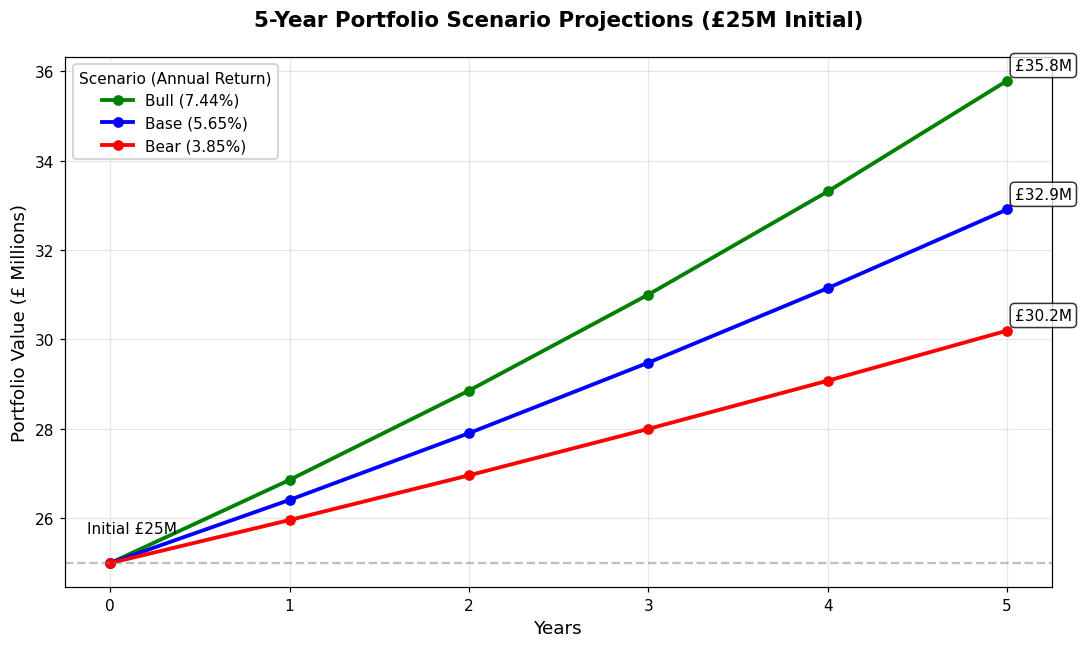

In [38]:
#Scenario Analysis
scenario_returns = {
    'Bull': {'Equities': 0.0975, 'Fixed Income': 0.05, 'Infrastructure': 0.08, 'Gold': 0.03, 'Cash': 0.025},
    'Base': {'Equities': 0.0650, 'Fixed Income': 0.045, 'Infrastructure': 0.06, 'Gold': 0.0475, 'Cash': 0.035},
    'Bear': {'Equities': 0.04,  'Fixed Income': 0.02, 'Infrastructure': 0.04, 'Gold': 0.07,  'Cash': 0.05}
}

# Define asset weights (assuming equal weights if not specified)
weights = {
    'Equities': 0.55,
    'Fixed Income': 0.25,
    'Infrastructure': 0.05,
    'Gold': 0.10,
    'Cash': 0.05
}

initial = 25_000_000  # £25 million
years = np.arange(6)  # 0-5 years

plt.figure(figsize=(10, 6))

# Colors for each scenario
colors = {'Bull': 'green', 'Base': 'blue', 'Bear': 'red'}

# Plot each scenario trajectory
for scen, rets in scenario_returns.items():
    # Calculate weighted portfolio return
    port_ret = sum(weights[a] * rets[a] for a in weights)
    
    # Calculate portfolio value for each year
    portfolio_values = [initial * ((1 + port_ret) ** year) / 1_000_000 for year in years]  # Convert to £ millions
    
    # Plot the line
    plt.plot(years, portfolio_values, 
             label=f'{scen} ({port_ret*100:.2f}%)', 
             color=colors[scen], 
             linewidth=2.5,
             marker='o')
    
    # Annotate the 5-year value
    plt.annotate(f'£{portfolio_values[-1]:.1f}M', 
                 xy=(years[-1], portfolio_values[-1]), 
                 xytext=(5, 5), textcoords='offset points',
                 ha='left', va='bottom', fontsize=10,
                 bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8))

# Formatting
plt.title('5-Year Portfolio Scenario Projections (£25M Initial)', fontsize=14, pad=20)
plt.xlabel('Years', fontsize=12)
plt.ylabel('Portfolio Value (£ Millions)', fontsize=12)
plt.xticks(years)
plt.grid(True, alpha=0.3)
plt.legend(title='Scenario (Annual Return)', framealpha=1)

# Add baseline reference
plt.axhline(y=initial/1_000_000, color='gray', linestyle='--', alpha=0.5)
plt.annotate('Initial £25M', xy=(0, initial/1_000_000), xytext=(-15, 20), 
             textcoords='offset points', color='black')

plt.tight_layout()
plt.show()